In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree #деревья решений
from sklearn.linear_model import LinearRegression
from sklearn import model_selection #методы разделения и валидации
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.feature_selection import SelectKBest, f_regression

## Загрузка данных

* price - Цена
* year - Год производства
* condition - Состояние
* cylinders - Количество цилиндров
* odometer - Пробег
* title_status - Статус авто
* transmission - Коробка передач
* drive - Привод
* size - Полноразмер или нет
* lat - Широта
* long - Долгота  
* weather - Среднегодовая температура в городе продажи   


In [207]:
data = pd.read_excel('data/data_ford_price.xlsx') 

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


## Предобработка данных

Удалим пропуски

In [209]:
data = data[['price','year', 'cylinders', 'odometer', 'lat', 'long', 'weather']]
data.dropna(inplace = True)

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6837 entries, 0 to 7016
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      6837 non-null   int64  
 1   year       6837 non-null   int64  
 2   cylinders  6837 non-null   int64  
 3   odometer   6837 non-null   int64  
 4   lat        6837 non-null   float64
 5   long       6837 non-null   float64
 6   weather    6837 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 427.3 KB


## Отбор признаков: классификация методов

### Метод рекурсивного исключения признаков

In [211]:
X = data.drop(columns='price')
y = data['price']


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=40)

In [212]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.83652139, 0.79156041, 0.79056239, 0.76056409, 0.77855396]),
 'score_time': array([0.00799537, 0.00798154, 0.00698256, 0.00699663, 0.00699663]),
 'test_score': array([0.1125731 , 0.11769006, 0.1214338 , 0.11777615, 0.0987564 ]),
 'train_score': array([0.16785518, 0.16840373, 0.16691042, 0.17184644, 0.17294333])}

In [213]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.17
Valid k-fold mean accuracy: 0.11


<Axes: >

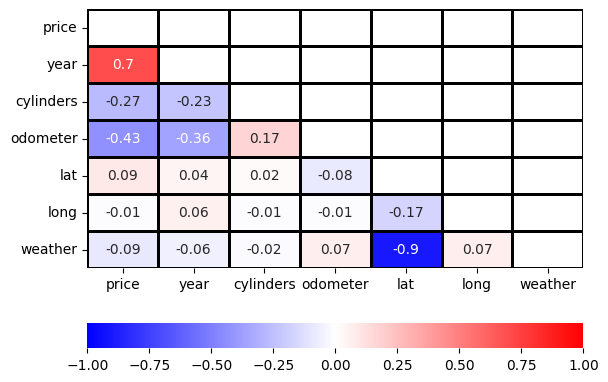

In [214]:
filtr_2=np.triu(data.corr(numeric_only=True).round(2))

temp=data.corr(numeric_only=True).round(2)

sns.heatmap(temp, # df
            annot=True, # вывод надписей (подписать фон)
            vmin=-1, vmax=1, center= 0,# граници тепловой шкалы
            cmap= 'bwr',    # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            linewidths=2, linecolor='black', # толщина и цвет оконтовки ячеек
            cbar_kws= {'orientation': 'horizontal'},  # отображать цветовую шкалу горизонтально
            # cbar=False,  # убрать цветовую шкалу
            # square=True,    # форма ячеек квадрат
            mask=filtr_2  # фильтор выводимых значений
            )

Выделим три наиболее значимых признака:

In [215]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

X_train = X_train[['year', 'cylinders', 'lat']]
X_test = X_test[['year', 'cylinders', 'lat']]
print(X_train.columns)
print(X_test.columns)

Index(['year', 'cylinders', 'lat'], dtype='object')
Index(['year', 'cylinders', 'lat'], dtype='object')


## Обучение модели

In [216]:
#Создаём объект класса LinearRegression
lr_model_rfe = linear_model.LinearRegression()

#Обучаем модель по МНК
lr_model_rfe.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model_rfe.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model_rfe.predict(X_test)
 
print("Train MAE score: {:.3f}".format(metrics.mean_absolute_error(y_train, y_train_predict)))
print("Test MAE score: {:.3f}".format(metrics.mean_absolute_error(y_test, y_test_predict)))

Train MAE score: 5283.260
Test MAE score: 5096.570


***

## Методы выбора признаков на основе фильтров


In [217]:
y = data['price']
x = data.drop(columns='price')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [218]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

X_train = X_train[['year', 'cylinders', 'odometer']]
X_test = X_test[['year', 'cylinders', 'odometer']]
print(X_train.columns)
print(X_test.columns)

Index(['year', 'cylinders', 'odometer'], dtype='object')
Index(['year', 'cylinders', 'odometer'], dtype='object')


## Обучение модели

In [219]:
#Создаём объект класса LinearRegression
lr_model_kbr = linear_model.LinearRegression()

#Обучаем модель по МНК
lr_model_kbr.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model_kbr.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model_kbr.predict(X_test)
 
print("Train MAE score: {:.3f}".format(metrics.mean_absolute_error(y_train, y_train_predict)))
print("Test MAE score: {:.3f}".format(metrics.mean_absolute_error(y_test, y_test_predict)))

Train MAE score: 4896.205
Test MAE score: 4708.946


## Вывод

Сравнение методов отбора признаков RFE и SelectKBest

На основе представленных данных о метриках MAE (Mean Absolute Error) для двух подходов:

### Метод RFE (Recursive Feature Elimination)

* Выбранные признаки: year, cylinders, lat

* Train MAE: 5283.260

* Test MAE: 5096.570

### Метод SelectKBest
* Выбранные признаки: year, cylinders, odometer

* Train MAE: 4896.205

* Test MAE: 4708.946

**Какой метод лучше?** Метод SelectKBest показал меньшие значения MAE (как на обучающей, так и на тестовой выборках). Меньший MAE говорит о том, что модель делает более точные предсказания. Это позволяет сделать вывод, что SelectKBest оказался более эффективным для данной задачи отбора признаков.

**Вывод:** Рекомендуется использовать метод SelectKBest, так как он улучшил качество модели, выбрав более релевантные признаки (в данном случае: year, cylinders, odometer).